# CENS Features and Shingles

<i>Chroma Energy Normalized Statistics</i> (CENS) are a post-processed variant of chroma features that are state-of-the-art for the task of cross-version retrieval.

This notebook aims at illustrating how these CENS features can be computed from a raw audio file, in the same way the they have been computed to carry out the retrieval experiements documented in my report. Moreover, the approach used to extract shingles  from the feature sequence is also illustrated.


Further details on the algorithmic steps and mid-level representations can be found in:  <b><i>Fundamentals of Music Processing</i></b> (Chapters 2, 3 and 7) and <b><a href="https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html">FMP Notebooks</a></b>


<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
This notebook was created as an addition to the Research Intenship Report: <b>Deep Learning Techniques for Cross-Version Retrieval of Music Recordings</b>. Therefore, theoretical contents might not completely be explained in detail. Please refer to the report for more in-depth explanations.  
</div> 

## Computing the Spectrogram

The first step towards calculating CENS features is to convert the audio data into a time-frequency representation. In our case, we have chosen this representation to be a spectrogram generated using a multirate filter bank consisting of IIR filters.

In [1]:
import os
import sys
import numpy as np
from scipy import signal
import librosa
from matplotlib import pyplot as plt
import IPython.display as ipd

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [3]:
root_path = "/".join(os.getcwd().split("\\")[:-1])
fn_audio = os.path.join(root_path, "audio_data", "FMP_C6_Audio_Debussy_SonataViolinPianoGMinor-02-sec135-SMD189.mp3")
FEATURE_RATE = 10
N = 4410
H = 2205

In [4]:
# loading first 20 seconds of an audio file
x, sr = librosa.load(fn_audio, sr=22050, mono=False)
ipd.display(ipd.Audio(fn_audio, rate=sr))

In [5]:
# computing spectrogram
hop_length = sr / FEATURE_RATE
X = librosa.spectrum.iirt(x, sr=sr, win_length=hop_length*2, hop_length=hop_length, center=True)

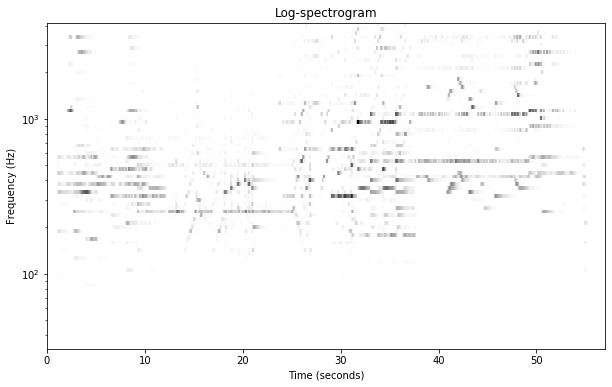

In [6]:
# displaying spectrogram
times = np.arange(X.shape[1]) * (hop_length / sr)
freqs = librosa.midi_to_hz(np.arange(24, 109))

plt.figure(figsize=(10,6))
plt.pcolormesh(times, freqs, np.log(1 + X), cmap="gray_r")
plt.yscale("log")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Log-spectrogram")
plt.show()

## Computing Chroma Features

Due to the fact that human hearing has a cyclic perception, pitch bands corresponding to pitches that differ by one or several octaves can be combined. <b>Chroma features</b> combine all spectral information that relates to a given pitch class into a single coefficient. Further remarks can be found in <a href="https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_SpecLogFreq-Chromagram.html">Chroma Features</a>

In [7]:
C = librosa.feature.chroma_stft(y=x, sr=sr, tuning=0, norm=2, hop_length=H, n_fft=N)

In [8]:
def display_chromogram(C, times, title="Chromogram"):
    """
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    plt.figure(figsize=(10,6))
    plt.imshow(C, origin='lower', aspect='auto', cmap='gray_r', extent=[times[0], times[-1], 0, 12])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Chroma')
    plt.title(title)
    plt.colorbar()
    plt.yticks(np.arange(12) + 0.5, chroma_labels)
    plt.tight_layout()
    plt.show()
    
def display_two_chromograms(C1, C2, times, title1="Chromogram", title2="Chromogram"):
    """
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    plt.figure(figsize=(16,5))
    
    plt.subplot(1,2,1)
    plt.imshow(C1, origin='lower', aspect='auto', cmap='gray_r', extent=[times[0], times[-1], 0, 12])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Chroma')
    plt.title(title1)
    plt.colorbar()
    plt.yticks(np.arange(12) + 0.5, chroma_labels)
    
    plt.subplot(1,2,2)
    plt.imshow(C2, origin='lower', aspect='auto', cmap='gray_r', extent=[times[0], times[-1], 0, 12])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Chroma')
    plt.title(title2)
    plt.colorbar()
    plt.yticks(np.arange(12) + 0.5, chroma_labels)
    
    plt.tight_layout()
    plt.show()

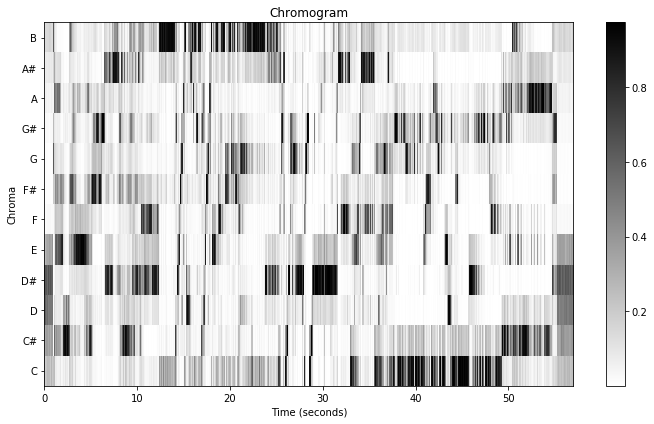

In [9]:
display_chromogram(C, times=times)

## Chroma Postprocessing

In order to obtain CENS from Chroma Features, a few postprocessing steps must be applied to the chomogram:

 - <b>Step 1:</b> Each chroma vector is normalized using the Manhattan norm ($\ell-1$ Norm)
 - <b>Step 2:</b> Values from the Chomogram are quantized in a logarithmic fashion using a quatization table
 - <b>Step 3:</b> Features are downsampled and temporal smoothing is applied
 - <b>Step 4:</b> Finally, each chroma vector is $\ell^2$-normalized.

The most important step in this process is Step-3 since, due to the temporal smoothing, these features show increased robustness to local tempo changes, making them state-of-the-art for the task of cross-version retrieval.

Further details about CENS features can be found in <a href="https://www.audiolabs-erlangen.de/resources/MIR/FMP/C7/C7S2_CENS.html">CENS Features</a>

In [10]:
def normalize_chromogram(C, ord=2):
    """
    Applying some norm to the chroma vectors
    """
    
    chroma, features = C.shape
    C_norm = np.zeros(C.shape)
    
    # iterating chroma vectors, applying them the L2 norm
    for i in range(features):
        
        if(ord==2):
            norm = np.sqrt(np.sum(C[:,i] ** 2))
        elif(ord==1):
            norm = np.sum(np.abs(C[:, i]))
        else:
            print("Error! Norm was not recognized")
            return
        
        C_norm[:, i] = C[:, i] / norm
    
    return C_norm

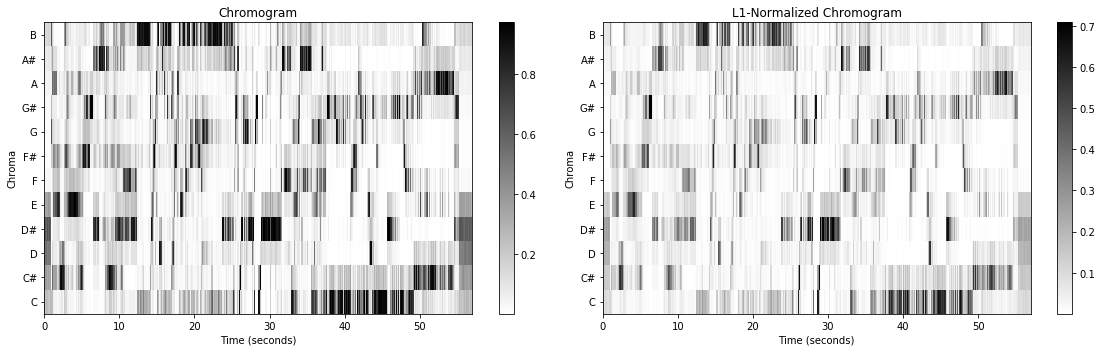

In [11]:
# Applying the L2-norm to the chroma vectors
C_manhattan = normalize_chromogram(C, ord=1)
display_two_chromograms(C1=C, C2=C_manhattan, times=times, title1="Chromogram", title2="L1-Normalized Chromogram")

In [12]:
def quantize_chromogram(C):
    """
    Quatizing the chromogram in a logarithmic fashion
    """
    
    C_quant= np.zeros(C.shape)
    
    # defining the logarithmic quatization table
    quant_fct = [(0.0, 0.05, 0), (0.05, 0.1, 1), (0.1, 0.2, 2), 
                 (0.2, 0.4, 3), (0.4, 1, 4)]
    
    # quatizing for each level
    for min_val, max_val, target_val in quant_fct:
        mask = np.logical_and(min_val <= C, C <=max_val)
        C_quant[mask] = target_val
    
    C_quant = C_quant/4
    
    return C_quant

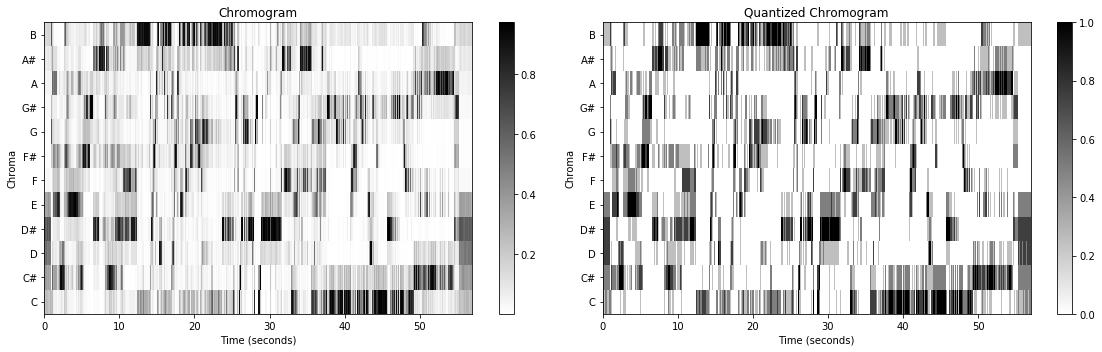

In [13]:
# quatizing the chromogram in a logarithmic fashion
C_Quatized = quantize_chromogram(C_manhattan)
display_two_chromograms(C1=C, C2=C_Quatized, times=times, title1="Chromogram", title2="Quantized Chromogram")

In [14]:
def smooth_and_downsample(C, filter_length=41, downsampling_factor=10, window_type="hann"):
    """
    Smoothing and downsampling the quantized chromogram
    """
    
    # generating a smoothing kernel given the window type, shape in (1, filter_length)
    smoother_kernel = signal.get_window(window_type, filter_length)[np.newaxis,:]
    
    # smoothing signal by convolving, and renormlizing the values
    C_smooth = signal.convolve(C, smoother_kernel, mode='same') / filter_length
    
    # downsompling accross the time axis
    C_downsampled = C_smooth[:,::downsampling_factor]
    
    return C_downsampled

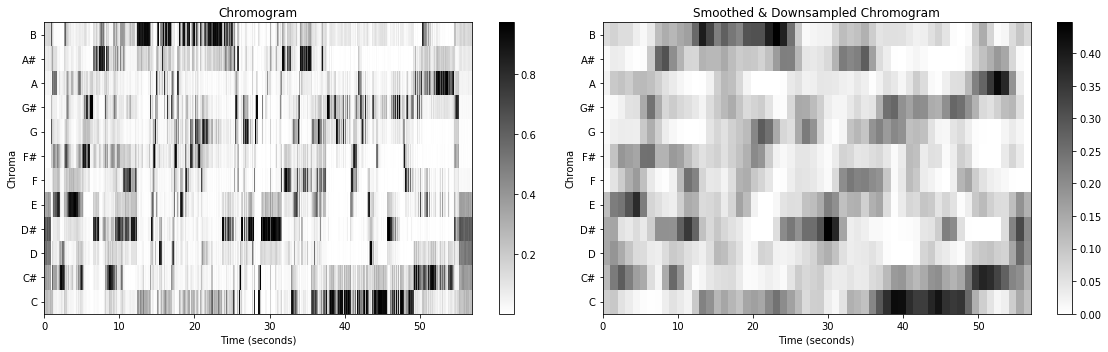

In [15]:
# Smoothing and downsampling the quantized chromogram
C_smooth = smooth_and_downsample(C_Quatized)
display_two_chromograms(C1=C, C2=C_smooth, times=times, title1="Chromogram", title2="Smoothed & Downsampled Chromogram")

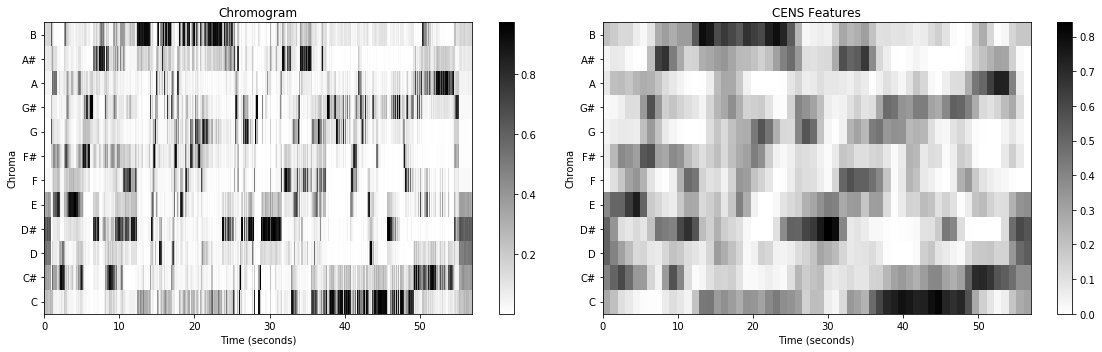

In [16]:
# Applying the L2-norm to the chroma vectors
C_norm = normalize_chromogram(C_smooth, ord=2)
display_two_chromograms(C1=C, C2=C_norm, times=times, title1="Chromogram", title2="CENS Features")

## Computing CENS Features

Despite the fact that we have seen how to compute CENS features from the spectrogram, the Librosa method <i>chroma_cens</i> was used in the cross-version retrieval pipline so as to compute these features. The following cells show how the output of the Librosa method is equivalent to performing the steps depicted above. 

In [17]:
def compute_CENS_features(C):
    """
    Computing CENS features from Spectrogram
    """
    
    C_manhattan = normalize_chromogram(C, ord=1)
    C_Quatized = quantize_chromogram(C_manhattan)
    C_smooth = smooth_and_downsample(C_Quatized)
    C_norm = normalize_chromogram(C_smooth, ord=2)
    
    return C_norm


def compute_CENS_librosa(C):
    """
    Computing CENS features using Librosa method
    """
    
    fmin = librosa.midi_to_hz(0)
    CENS_librosa = librosa.feature.chroma_cens(C=C, fmin=fmin, bins_per_octave=12, n_octaves=7,
                                               win_len_smooth=41, norm=2)[:, ::10]
    
    return CENS_librosa

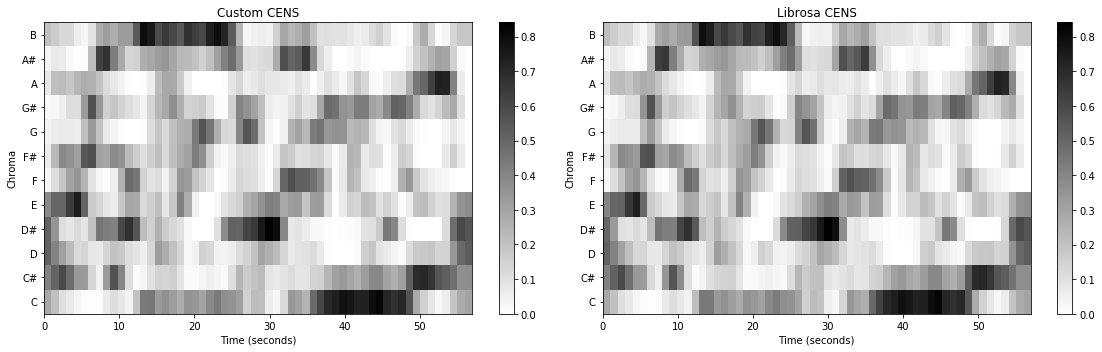

In [18]:
CENS = compute_CENS_features(C)
CENS_librosa = compute_CENS_librosa(C)

display_two_chromograms(C1=CENS, C2=CENS_librosa, times=times, title1="Custom CENS", title2="Librosa CENS")

In [19]:
normed_error = np.linalg.norm(CENS-CENS_librosa, ord=2)
print(f"Difference between Custom and Librosa cens is {normed_error}")

Difference between Custom and Librosa cens is 0.07425667451801239


## Extracting Shingles

From these CENS features, the so-called shingles are extracted. 

We denote as <b>Shingle</b> to short segments of fixed length extracted from the feature sequence. In our cross-version retrieval scenario, the chosen length (L) was 20 seconds and the hop-size (H) was 1. The cells below illustrate how we extract shingles from CENS feature sequences in our pipeline.

In [20]:
def get_max_num_shingles(S, L=20, H=1):
    """
    Obtaining the maximum number of shingles that can be extracted from a sequence
    """
    
    num_shingles = np.floor((S.shape[1]-L)/H)
    
    return int(num_shingles)

def extract_shingles(S, num_shingles=1, L=20, H=1):
    """
    Extracting a desired number of shingles from a feature sequence    
    """
    
    # obtaining number of shingles that can be extracted
    max_num_shingles = get_max_num_shingles(S, L=L, H=H)
    num_shingles = min(num_shingles, max_num_shingles)
    
    # obtaining indexes from which shingles will be extracted
    shingle_idx = np.round(np.linspace(0, max_num_shingles, num_shingles)).astype('int')
    
    shingles = np.empty((num_shingles, 12, L))
    crop_times = []
    
    # extracting shingles from feature sequence
    for i, idx in enumerate(shingle_idx):
        crop_times.append([idx,idx+L])
        shingles[i,:,:] = S[:,idx:idx+L]
        
    return shingles, crop_times

In [21]:
max_num_shingles = get_max_num_shingles(CENS, L=20, H=1)
print(f"{max_num_shingles} shingles can be extracted from the feature sequence")
shingles, crop_times = extract_shingles(CENS, num_shingles=4, L=20, H=1)

38 shingles can be extracted from the feature sequence


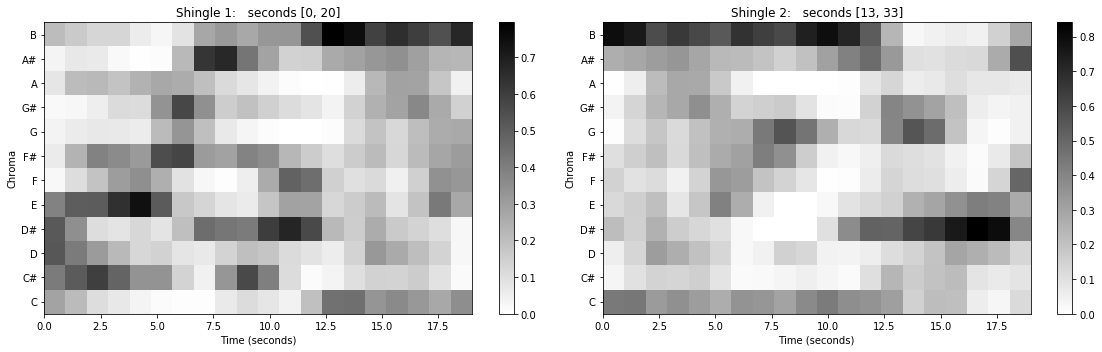

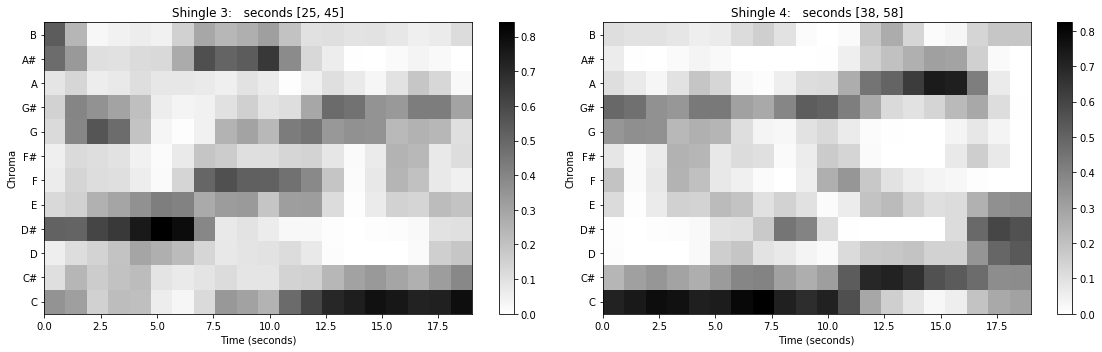

In [22]:
times = np.arange(20)
display_two_chromograms(C1=shingles[0,:], C2=shingles[1,:], times=times, 
                        title1=f"Shingle 1:   seconds {crop_times[0]}", title2=f"Shingle 2:   seconds {crop_times[1]}")
display_two_chromograms(C1=shingles[2,:], C2=shingles[3,:], times=times,
                        title1=f"Shingle 3:   seconds {crop_times[2]}", title2=f"Shingle 4:   seconds {crop_times[3]}")

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
This notebook was created by Angel Villar-Corrales
</div> 